# 项目概述
这个项目的目标是 Monte Carlo 数值模拟在金融模型的应用；在实现的过程中分别使用传统的numpy以及Pytorch进行计算，比较两种不同方式的计算速度；最终应用不同缩减方差的方法

## 基于 Numpy 利用 Monte Carlo 对于 Black-Scholes 模型的实现

In [34]:
## ------------------------
## 基础库的导入
## ------------------------
import math                      ## 基础数学函数
import time                      ## 计时，用于比较不同算法的速度
import os                        ## 文件/路径管理
import pickle                    ## 保存和加载Python对象（模拟结果、模型参数）

## ------------------------
## 数值计算
## ------------------------
import numpy as np               ## 向量计算（模拟布朗运动）
import scipy.stats as sps        ## 正态分布（Black-Scholes模型构建）

## ------------------------
## 绘图与可视化
## ------------------------
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme()                  ## 统一绘图风格
## ------------------------
## 表格与进度条展示
## ------------------------
import pandas as pd              ## 数据处理，表格化处理结果
from tqdm import tqdm            ## 循环时展现进度条

## ------------------------
## 生成随机数
## ------------------------
from numpy.random import default_rng, SeedSequence
sq = SeedSequence()              ## 创建可复现的随机种子对象
seed = sq.entropy                ## 保存随机种子，保证实验结果可以复现      
rng = default_rng(sq)            ## 创建随机数生成器

## 研究的流程与思想

1. **研究目标**  
我们的目标是通过 Monte Carlo 数值模拟的方法，计算出期权在风险中性测度下的理论价格 $ V = \mathbb{E} [e^{-rT} Payoff(S_T)] $




2. **研究流程与思想**  
- model_bs函数：确定资产价格的随机演化模型（比如 Black-Scholes 模型）的参数。  
- phi函数：确定我们要应用的金融模型，利用模型参数将模型表示为对标准随机变量的确定性变换（在本项目中，我们把资产价格表示为标准正态向量 $G$ 的函数 $S_T = \Phi(G)$），方便进行后续模拟以及方差缩减。 
- sampling_payoff函数：生成大量的独立同分布的随机样本（比如标准正态向量），通过我们选择的模型得到对应的资产价格公式，并计算每条路径的payoff
- monte_carlo_adaptive函数：进行 Monte Carlo 数值模拟
- 方差缩减

## Monte Carlo 估计与置信区间

### 样本与估计量

对于一个大小为 $n$ 的样本 $(X_1, X_2, \ldots, X_n)$，Monte Carlo 估计量基于 **样本均值** 和 **样本方差** 来构造，定义如下：

$$\bar{X}_n = \frac{1}{n}\sum_{i=1}^{n} X_i$$

$$S_n^2 = \frac{1}{n-1}\sum_{i=1}^{n} (X_i - \bar{X}_n)^2$$

其中 $\bar{X}_n$ 是样本均值，$S_n^2$ 是样本方差。

---

### 置信区间的构造

在**中心极限定理**的假设下，当 $n$ 足够大时，标准化的样本均值渐近服从正态分布：

$$\sqrt{n}\left(\bar{X}_n - \mathbb{E}[X]\right) \xrightarrow{\mathcal{L}} \mathcal{N}\left(0, \sigma^2\right)$$

因此，置信水平为 $1-\alpha$ 的置信区间为：

$$\left[\bar{X}_n - z_{1-\alpha/2}\frac{S_n}{\sqrt{n}}, \quad \bar{X}_n + z_{1-\alpha/2}\frac{S_n}{\sqrt{n}}\right]$$

其中：
- $z_{1-\alpha/2}$ 是标准正态分布 $\mathcal{N}(0,1)$ 的 $1-\alpha/2$ 分位数

In [2]:
## ---------------------------------
## 定义自适应 Monte Carlo 模拟器
## ---------------------------------

def monte_carlo_adaptive(sampling_function, epsilon: float, 
                         batch_size: int = 100000, 
                         proba: float = 0.95) -> dict:
    """
    Monte Carlo 自适应模拟：
    Monte Carlo 根本目标上就是对期望的估计和模拟，给出一组样本就可以生成样本均值（期望的无偏估计）和对应的置信区间
    根据大数定率，当样本量足够大时结果会收敛；
    我们的思想就是以batch_size的倍数为样本数量，持续进行 Monte Carlo 模拟，直到均值的置信区间长度小于给定的 epsilon。

    参数:
    - sampling_function (callable): 一个采样函数（以样本数量作为参数，输出对应数量的随机样本）
    - epsilon (float): 置信区间允许的最大长度
    - proba (float): 置信区间的置信水平（默认为0.95）
    - batch_size (int): 每一批 Monte Carlo 模拟的样本数量（默认为100000）

    返回值:
    - dict: 包含以下变量的字典:
        - "mean" (float): 样本均值
        - "var" (float): 样本方差
        - "ci_size" (float): 置信区间的长度
        - "samples_size" (int):总共使用的样本数量
        - "time (s)" (float): 算法运行的总时间（单位：秒）
    """
    alpha = 1 - proba                                                    ## 置信区间的显著性水平
    quantile = sps.norm.ppf(1 - alpha / 2)                               ## 计算标准正态分布的分位数

    
    ## 在应用 Monte Carlo 模拟的时候，我们需要计算样本均值，但是每一次模拟都对全部样本求和会很浪费算力跟时间
    ## 所以我们每一次模拟的时候都把“和”储存，在下一次模拟时就可以在这个基础上进行计算
    sum_, sum2_, size_ = 0, 0, 0                                         ## sum_是样本和；sum2_是样本的平方和；size是样本总数
    start = time.time()                                                  ## 记录开始时间
    with tqdm(total=None, desc="Adaptive Monte Carlo") as pbar:          ## 创建一个进度条，total = None因为我们不知道一共多少样本
        while True:
            # 生成一批新的样本
            samples = sampling_function(batch_size)
            sum_ += samples.sum().item()
            sum2_ += (samples**2).sum().item()
            size_ += batch_size

            mean = sum_ / size_
            var = size_ / (size_-1) * (sum2_ / size_ - mean**2)          ## 计算的是无偏样本方差
            ci_size = 2 * quantile * math.sqrt(var / size_)              ## 计算置信区间的长度
    
            # 使用当前置信区间的长度来更新显示信息
            pbar.set_postfix({"IC_size": ci_size, "mean": mean, "var": var})
            pbar.update(batch_size)
            
            # 若置信区间长度满足要求，则停止模拟
            if ci_size <= epsilon:
                break
    stop = time.time()                                                   ## 记录停止时间
    return {
        "mean": mean,
        "var": var,
        "ci_size": ci_size,
        "samples_size": size_,
        "time (s)": stop-start,
    }

In [3]:
## ---------------------------------
## 多资产 Black-Scholes 模型参数的封装
## ---------------------------------
def model_bs(d, r, S0, sigma, correlation, T):
    
    """
    多资产 Black-Scholes 模型参数的初始化

    参数:
    - d (int): 维度，表示 basket option 中的资产数量
    - r (float): 无风险利率
    - S0 (np.ndarray): 长度为d的初始价格向量，第i个分量表示第i个资产的初始价格
    - sigma (np.ndarray): 长度为d的波动率向量，第i个分量表示第i个资产的波动率
    - correlation (np.ndarray): d*d的相关性矩阵，用来描述两个资产之间的线性相关性
    - T (float): 期权的到期时间

    输出:
    - dict: 包含了以下用来描述 Black-Scholes 模型参数的字典：
        - d
        - r
        - S0
        - sigma
        - mu (float): Black-Scholes模型的风险中性漂移项，用于计算对数价格过程
        - correlation
        - correlation_cholesky: 对相关矩阵做cholesky分解，用于从独立的标准正态向量生成相关的正态向量
        - T
        - actualization: 折现因子，用于 payoff 贴现时候的定价
    """
    
    return {
        "d": d,
        "r": r,
        "S0": S0,
        "sigma": sigma,
        "mu": r - 0.5 * sigma**2,                   
        "correlation": correlation,
        "correlation_cholesky": np.linalg.cholesky(correlation),
        "T": T,
        "actualization": math.exp(-r * T)
    }


## 带入一部分具体数值用于后续计算
d = 40
rho = 0.3
bs = model_bs(d=d, r=0.1, S0=np.full((d), 100), 
              sigma=np.full((d), 0.3), 
              correlation=np.full((d,d), rho) + (1-rho)*np.eye(d),
              T=1)



## Black-Scholes 数学模型的搭建
我们考虑我们考虑 $d$ 个金融资产，其在时刻 $T$ 的分布被建模为对数正态分布，即：

$$ S_T = (S_T^1, \ldots, S_T^d) $$

满足：

$$ \forall i \in \{1, \ldots, d\},\ \ \ \ \  S_T^i = S_0^i exp\big((r-\frac{\sigma_i^2}{2})T + \sigma_i \sqrt{T}\tilde{G}_i\big) $$

其中随机向量 $(\tilde{G}_1, \ldots, \tilde{G}_d)$ 是一个均值为 $0$，协方差矩阵为 $\Sigma$ 的高斯向量，常数 $r>0$，$\sigma_i > 0$ 为给定的参数。这些资产 $(S_t^i)_{t\in [0,T]},\ 1 \le i \le d$ 由一个多维的Black-Scholes过程进行建模。我们引入矩阵 $L$，它是协方差矩阵 $\Sigma$ 经过cholesky分解 $\Sigma = LL^T$ 所得到的下三角矩阵。

借助这个矩阵 $L$，我们可以定义相关的高斯向量 $\tilde{G} = LG$ 进而定义函数 $\Phi: \mathbb{R}^d \rightarrow \mathbb{R}^d$ 使得

$$ (S_T^1, \ldots, S_T^d) = \Phi (G_1, \ldots, G_d)$$
$$ \tilde{G}_i = \sum_{j=1}^d L_{ij}\, G_j $$

其中:

$$(G_1, \ldots, G_d)\sim \mathcal N(0, I_d)$$

$$(\tilde{G}_1, \ldots, \tilde{G}_d) \sim \mathcal N(0, \Sigma)$$



In [4]:
## ----------------------------------------------------------------------------------
## 定义函数 phi 由第 n 次 Monte Carlo 模拟中用到的标准正态随机向量 Gn 生成 T 时刻资产的价格 S_T
## ----------------------------------------------------------------------------------
def phi(bs, Gn):
    
    """
    参数：
    - bs(dict): 由前面定义的函数 model_bs 生成的结果，里面包含了Black-Scholes模型的各种参数
    - Gn(np.ndarray): 是一个 N*d 维的标准高斯向量，表示一共 N 次 Monte Carlo 模拟中的每一次用到的高斯向量
    
    输出：
    - ST(np.ndarray)：是一个 N*d 维的向量，每一次 Monte Carlo 模拟最终得到的 T 时刻所有资产的价格；有 d 个资产所以是 d 维
    """
    
    mu_T = bs["mu"] * bs["T"]
    sig_T = bs["sigma"] * math.sqrt(bs["T"]) * bs["correlation_cholesky"] 
    ST = bs["S0"] * np.exp(mu_T + np.einsum('ij,pj->pi', sig_T, Gn))
    return ST

接下来的函数 sampling_payoffs 做了以下工作：  

1. 模拟随机向量 $G$  
- 实际上是生成了一个维度为 size 的向量，代表多条 Monte Carlo 模拟路径；每一个元素是一个 $\mathbb{R}^d$ 中的向量，代表了 d 个资产。  

2. 通过调用函数 phi 来应用金融模型  
- 在这里我们选择的是 Black-Scholes 模型，如果选择其它金融模型需要对 phi 函数进行更改。  
- phi 函数将标准正态向量转换为到期时刻 $T$ 的资产价格向量 $S_T$。  

3. 通过给出的 payoff 表达式计算每条 Monte Carlo 路径对应期权的贴现 payoff $g: \mathbb{R}^d \rightarrow \mathbb{R}$  

$$ g(S_T) = \big(\frac{1}{d} \sum_{i=1}^{d} S_T^i - K \big)_{+} $$



In [5]:
## ----------------------------------------------------------------
## 定义函数 sampling_payoff 计算 N 条 Monte Carlo 路径上的贴现 payoff
## ----------------------------------------------------------------
def sampling_payoffs(K, size, bs, rng): 
    
    """
    参数：
    - K(float)：期权的执行价
    - size(int)：Monte Carlo 模拟的路径数量
    - bs(dict)：函数 model_bs 的输出结果，包含了 Black-Scholes 模型的参数
    - rng：随机数生成器（在导入库时定义的）
    
    返回值：
    - bs["actualization"] * payoffs：一个维度为 size 的 numpy 数组，表示 N 个路径上计算得到的 payoff 贴现值
    """
    
    Gn = rng.standard_normal((size, bs["d"]))              # 生成 size*d 个服从标准正态分布的随机数
    samples = phi(bs, Gn)                                  # 计算 T 时刻资产价格
    payoffs = np.maximum(np.mean(samples, axis=1)-K, 0.)   # 计算 T 时刻的 payoff
    return bs["actualization"] * payoffs                   # 返回每个路径的贴现价格

接下来我们要定义一个函数 run 来封装对不同的执行价 K 调用 monte_carlo_adaptive 来计算的过程：  
- 我们要考虑 $K \in \{80, 90, 100, 110, 120 \}$ 的情况。
- 在这里将 sampling_payoff 作为参数传入，以便以后在决策是否更改金融模型、更换 payoff 表达式、使用方差缩减时更方便操作。

In [6]:
def run(name, function, epsilon, batch_size, **kwargs): 
    
    """
    参数：
    - name(字符串)：用来标记方法的名称（"numpy", "pytorch"）
    - function(一个函数)：用来生成贴现价格的函数，不同的 payoff 公式与金融模型换不同的函数（比如 sampling_payoffs)
    - epsilon(float)：控制置信区间长度的参数
    - batch_size(int)：每次 Monte Carlo 模拟时选定样本量的大小
    - **kwargs：传给 function 的其它参数
    """
    path = os.getcwd()
    filename = path + name + ".pkl"                        ## 构建结果的文件名称
    if os.path.exists(filename):                           ## 检查是否存在文件名（如果存在就说明之前已经跑过，可以直接读取结果）
        with open(filename, "rb") as file: 
            result_df = pickle.load(file)
    else:
        result = {}                                          ## 初始化一个字典用于储存不同 K 值的结果
        for K in [80, 90, 100, 110, 120]:                    ## 遍历 K
            result[K] = monte_carlo_adaptive(                ## 对当前 K 调用 monte_carlo_adaptive，返回一个字典
              lambda size: function(K, size, **kwargs),    ## 新定义了一个函数，只接受参数 size，返回的值为 function(...)
              epsilon=epsilon, 
              batch_size=batch_size)
        result_df = pd.DataFrame(result).T                   ## 将 K 值为列键值为行的 dataframe 转换成 K 值为行键值为列
        result_df["K"] = result_df.index                     ## 把索引的 K 值显式地存为一列，方便后面分析
        result_df["method"] = name                           ## 标记所用的方法
        with open(filename, "wb") as file:                   ## 将结果存储到磁盘，方便后续直接读取结果
            pickle.dump(result_df, file)
    return result_df

In [7]:
## ----------------------------------------------------------------
## 验证在 numpy 下算法的执行时间与 Monte Carlo 模拟中使用的样本数量成正比
## ----------------------------------------------------------------

epsilon = 0.01
batch_size = int(1e6)
result_numpy = run("numpy", sampling_payoffs, epsilon=epsilon, 
    batch_size=batch_size, bs=bs, rng=rng)
result_numpy

Adaptive Monte Carlo: 44000000it [00:39, 1111400.84it/s, IC_size=0.0099, mean=27.8, var=281]
Adaptive Monte Carlo: 39000000it [00:35, 1110903.08it/s, IC_size=0.00993, mean=19.4, var=250]
Adaptive Monte Carlo: 30000000it [00:27, 1110750.40it/s, IC_size=0.00991, mean=12.3, var=192]
Adaptive Monte Carlo: 19000000it [00:17, 1109084.73it/s, IC_size=0.00996, mean=6.96, var=123]
Adaptive Monte Carlo: 11000000it [00:09, 1110472.10it/s, IC_size=0.0096, mean=3.55, var=65.9]


,mean,var,ci_size,samples_size,time (s),K,method
80,27.769228,280.656843,0.009900,44000000.0,39.606293,80,numpy
90,19.396786,250.017076,0.009925,39000000.0,35.107162,90,numpy
100,12.263230,191.638426,0.009907,30000000.0,27.009516,100,numpy
110,6.958735,122.624029,0.009958,19000000.0,17.131909,110,numpy
120,3.550940,65.918039,0.009596,11000000.0,9.906296,120,numpy


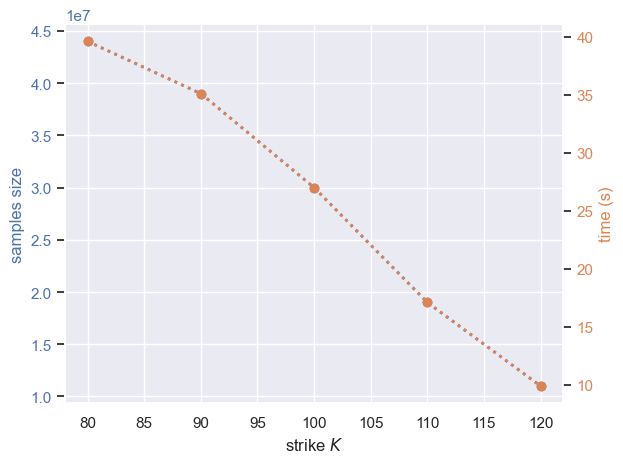

In [9]:
## -----------------------------------------------------
## 在 numpy 下不同行权价、不同样本量对应的运行时间图像
## -----------------------------------------------------

fig, ax1 = plt.subplots(layout="tight")                    ## 创建图像和第一个 y 轴

color = 'C0'
ax1.set_xlabel(r'strike $K$')                              ## 设置 x 轴标签
ax1.set_ylabel('samples size', color=color)                ## 设置 y 轴（左侧）标签
ax1.plot(result_numpy["K"], result_numpy["samples_size"],  ## 画样本数量随行权价 K 的
         marker="o", ls=':', lw=2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'C1'
ax2.set_ylabel('time (s)', color=color)                    ## 设置第二个 y 轴（与第一个共用一个 x 轴）
ax2.plot(result_numpy["K"], result_numpy["time (s)"],      ## 画运行时间随 K 值的图像
         marker="o", ls=':', lw=2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False);

## 基于 Pytorch 利用 Monte Carlo 对于 Black-Scholes 模型的实现

---
- PyTorch 是一个开源的科学计算与机器学习库，在学术研究和工业界都被广泛使用。它最初是为深度学习模型的开发与训练而设计的，但同时也提供了强大的数值模拟与概率计算工具。

---
- PyTorch 的核心是对张量（tensor）的操作。张量是多维数据结构，类似于矩阵，但可以具有任意维度，这使得在处理大规模数据时能够进行快速而高效的运算。

---
- PyTorch 可以在 GPU 上执行计算，从而在计算资源密集型任务中显著提升性能。

---
- 自动微分（Autograd） 是 PyTorch 的一大优势。该系统能够自动计算梯度，从而大大简化复杂函数的优化过程。这一点在深度学习模型的训练中至关重要。

---
- 从 NumPy 代码迁移到 PyTorch 代码 时，主要的变化是将 np.ndarray 替换为 torch.tensor。
此外，PyTorch 引入了 device（设备） 的概念，用于指定计算是在 CPU 还是 GPU 上进行。

### Pytorch 在 CPU 上实现

In [10]:
## -----------------------------------------------------
## 导入 pytorch 库、指定 CPU 计算以及创建随机数生成器
## -----------------------------------------------------

import torch
dtype = torch.float32
device = torch.device("cpu")
rng_torch = torch.Generator(device=device)                ## 创建 pytorch 随机数生成器

In [12]:
## -----------------------------------------------------
## 将 Black-Scholes 模型参数转变为 pytorch 中的张量储存 (cpu)
## -----------------------------------------------------

bs_torch_cpu = {}                                         ## 创建一个空字典储存利用 pytorch 生成的参数
                                                          
for key, item in bs.items():                              ## 我们在先前的 bs 基础上进行修改，pytorch 与 numpy 结果的差异只在把 numpy 和 tensor 张量
    if type(item) == np.ndarray:                          ## 对于值的类型为 numpy 数组的，我们将它转换成 tensor 张量
        bs_torch_cpu[key] = torch.tensor(item, dtype=dtype, device=device)
    else:
        bs_torch_cpu[key] = item

In [13]:
## -----------------------------------------------------------------------------------------
## 利用 pytorch 重新定义 phi 函数（只需要把 np.exp 和 np.einsum 换成 torch.exp 和 torch.einsum
## -----------------------------------------------------------------------------------------

def phi_torch(bs, Gn):
    mu_T = bs["mu"] * bs["T"]
    sig_T = bs["sigma"] * math.sqrt(bs["T"]) * bs["correlation_cholesky"] 
    ST = bs["S0"] * torch.exp(mu_T + torch.einsum('ij,pj->pi', sig_T, Gn)) 
    return ST

In [14]:
## -----------------------------------------------------
## 利用 pytorch 重新定义 sampling_payoffs
## -----------------------------------------------------

def sampling_payoffs_torch(K, size, bs, device, rng): 
    
    """
    虽然 NumPy 和 PyTorch 中部分函数具有相同的名称，但它们的接口并不完全一致。
    特别地，torch.maximum 只能作用于两个 tensor。
    在期权定价中，为了实现取正部分的 payoff，可以使用 torch.nn.functional.relu。
    其数学定义与 payoff 完全一致，并且在 PyTorch 中使用更加自然。
    """
    
    Gn = torch.randn((size, bs["d"]), dtype=dtype, device=device, generator=rng)
    samples = phi_torch(bs, Gn)
    payoffs = torch.nn.functional.relu(torch.mean(samples, axis=1) - K)
     
    return bs["actualization"] * payoffs

In [15]:
## -----------------------------------------------------
## 将新的方法 torch_cpu 替换函数 run 中的参数
## -----------------------------------------------------

result_torch_cpu = run("torch_cpu", sampling_payoffs_torch, epsilon=epsilon, 
    batch_size=batch_size, bs=bs_torch_cpu, device=device, rng=rng_torch)
result_torch_cpu

Adaptive Monte Carlo: 44000000it [00:19, 2250664.26it/s, IC_size=0.0099, mean=27.8, var=281]
Adaptive Monte Carlo: 39000000it [00:17, 2269438.46it/s, IC_size=0.00993, mean=19.4, var=250]
Adaptive Monte Carlo: 30000000it [00:13, 2261707.63it/s, IC_size=0.00991, mean=12.3, var=192]
Adaptive Monte Carlo: 19000000it [00:08, 2260749.85it/s, IC_size=0.00996, mean=6.96, var=123]
Adaptive Monte Carlo: 11000000it [00:04, 2259434.00it/s, IC_size=0.0096, mean=3.55, var=65.9]


,mean,var,ci_size,samples_size,time (s),K,method
80,27.769638,280.706231,0.009901,44000000.0,19.551427,80,torch_cpu
90,19.399927,250.090584,0.009926,39000000.0,17.185516,90,torch_cpu
100,12.259753,191.608454,0.009907,30000000.0,13.264929,100,torch_cpu
110,6.963109,122.697587,0.009961,19000000.0,8.404858,110,torch_cpu
120,3.552352,65.912914,0.009595,11000000.0,4.869054,120,torch_cpu


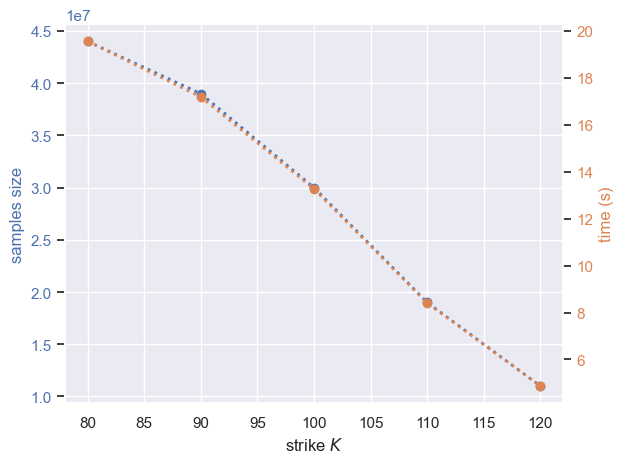

In [18]:
## -----------------------------------------------------
## 在 pytorch 下不同行权价、不同样本量对应的运行时间图像
## -----------------------------------------------------

fig, ax1 = plt.subplots(layout="tight")                    ## 创建图像和第一个 y 轴

color = 'C0'
ax1.set_xlabel(r'strike $K$')                              ## 设置 x 轴标签
ax1.set_ylabel('samples size', color=color)                ## 设置 y 轴（左侧）标签
ax1.plot(result_torch_cpu["K"], result_torch_cpu["samples_size"],  ## 画样本数量随行权价 K 的
         marker="o", ls=':', lw=2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'C1'
ax2.set_ylabel('time (s)', color=color)                    ## 设置第二个 y 轴（与第一个共用一个 x 轴）
ax2.plot(result_torch_cpu["K"], result_torch_cpu["time (s)"],      ## 画运行时间随 K 值的图像
         marker="o", ls=':', lw=2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False);

### Pytorch 在 GPU 上实现

In [20]:
## device = torch.device("cuda")                      ## windows 上用 "cuda"
device = torch.device("mps")                          ## mac 上用 "mps"
rng_torch = torch.Generator(device=device)

In [21]:
## -----------------------------------------------------
## 将 Black-Scholes 模型参数转变为 pytorch 中的张量储存 (gpu)
## -----------------------------------------------------

bs_torch_gpu = {}                                         ## 创建一个空字典储存利用 pytorch 生成的参数
                                                          
for key, item in bs.items():                              ## 我们在先前的 bs 基础上进行修改，pytorch 与 numpy 结果的差异只在把 numpy 和 tensor 张量
    if type(item) == np.ndarray:                          ## 对于值的类型为 numpy 数组的，我们将它转换成 tensor 张量
        bs_torch_gpu[key] = torch.tensor(item, dtype=dtype, device=device)
    else:
        bs_torch_gpu[key] = item

In [22]:
## -----------------------------------------------------
## 将新的方法 torch_gpu 替换函数 run 中的参数
## -----------------------------------------------------

result_torch_gpu = run("torch_gpu", sampling_payoffs_torch, epsilon=epsilon, 
    batch_size=batch_size, bs=bs_torch_gpu, device=device, rng=rng_torch)
result_torch_gpu

Adaptive Monte Carlo: 44000000it [00:01, 33618484.38it/s, IC_size=0.0099, mean=27.8, var=281]
Adaptive Monte Carlo: 39000000it [00:00, 39221961.13it/s, IC_size=0.00993, mean=19.4, var=250]
Adaptive Monte Carlo: 30000000it [00:00, 39252001.30it/s, IC_size=0.00991, mean=12.3, var=192]
Adaptive Monte Carlo: 19000000it [00:00, 39246379.92it/s, IC_size=0.00996, mean=6.96, var=123]
Adaptive Monte Carlo: 11000000it [00:00, 39232301.93it/s, IC_size=0.0096, mean=3.55, var=66] 


,mean,var,ci_size,samples_size,time (s),K,method
80,27.766539,280.602046,0.009899,44000000.0,1.310510,80,torch_gpu
90,19.393481,250.056329,0.009926,39000000.0,0.995179,90,torch_gpu
100,12.261247,191.699102,0.009909,30000000.0,0.765017,100,torch_gpu
110,6.962067,122.706001,0.009962,19000000.0,0.484967,110,torch_gpu
120,3.552577,65.978644,0.009600,11000000.0,0.281088,120,torch_gpu


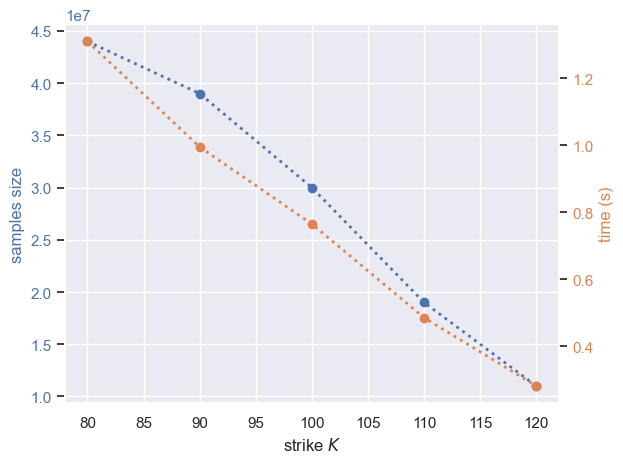

In [25]:
## -----------------------------------------------------
## 在 pytorch 下不同行权价、不同样本量对应的运行时间图像
## -----------------------------------------------------

fig, ax1 = plt.subplots(layout="tight")                    ## 创建图像和第一个 y 轴

color = 'C0'
ax1.set_xlabel(r'strike $K$')                              ## 设置 x 轴标签
ax1.set_ylabel('samples size', color=color)                ## 设置 y 轴（左侧）标签
ax1.plot(result_torch_gpu["K"], result_torch_gpu["samples_size"],  ## 画样本数量随行权价 K 的
         marker="o", ls=':', lw=2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'C1'
ax2.set_ylabel('time (s)', color=color)                    ## 设置第二个 y 轴（与第一个共用一个 x 轴）
ax2.plot(result_torch_gpu["K"], result_torch_gpu["time (s)"],      ## 画运行时间随 K 值的图像
         marker="o", ls=':', lw=2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False);

我们观察到，时间随行权价格函数与样本数量随行权价格函数的点在GPU的结果中并不重合，这是因为在 GPU 上，运行时间不再严格与模拟的样本数量成正比。这可以由以下因素解释：内核启动所带来的固定开销、异步执行机制以及使用单精度（float32）计算，这些因素都会影响 Monte Carlo 自适应算法中的停止准则。

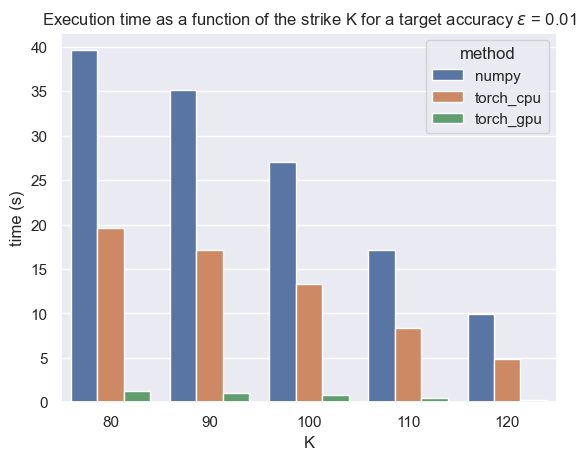

In [36]:
result = pd.concat([ result_numpy, result_torch_cpu, result_torch_gpu ])
ax = sns.barplot(data=result, x="K", y="time (s)", hue="method")
ax.set_title(fr"Execution time as a function of the strike K for a target accuracy $\epsilon$ = {epsilon}");

## 利用反向变量进行方差缩减

金融模型是通过函数 phi 来实现的，在讨论方差缩减的问题时我们要固定函数 phi，通过修改函数 sampling_payoffs 来实现方差缩减的方法。  

因为方差缩减的方法会提高估计效率，所以进行 Monte Carlo 模拟时所需的样本数量会减少。因此我们在使用自适应 Monte Carlo 的方法时，我们可以调整参数 batch_size 的大小。

因为标准正态分布是一个对称的分布，$G \sim \mathcal{N}(0, Id_d)$，我们利用随机向量 $G$ 与 $-G$ 具有相同相同分布的事实：

$$ \mathbb{E} [(g \circ \Phi)(G)] = \frac{1}{2} \mathbb{E} [(g \circ \Phi)(G) + (g \circ \Phi)(-G)] $$

---
这表明我们可以用 $G$ 与 $-G$ 的平均值来替代 $G$ 来构造一个新的 Monte Carlo 模拟器：

$$ \tilde{I}_n = \frac{1}{2n} \sum_{i=1}^{n} \big((g \circ \Phi)(G_i) + （g \circ \Phi）(-G_i)\big) $$

其中 $(G_i)_{i \geq 1} \sim \mathcal{N}(0, Id_d)$ 是一列独立同分布的随机变量.

In [37]:
## ------------------------------------------------
## 使用 numpy 来实现反向变量法
## ------------------------------------------------
def sampling_payoffs_antithetic(K, size, bs, rng): 
    Gn = rng.standard_normal((size, bs["d"]))
    payoffs_1 = np.maximum(np.mean(phi(bs, Gn), axis=1) - K, 0) 
    payoffs_2 = np.maximum(np.mean(phi(bs, -Gn), axis=1) - K, 0) 
    payoffs = 0.5 * (payoffs_1 + payoffs_2)
    return bs["actualization"] * payoffs

In [38]:
batch_size = int(1e5)
result_antithetic = run("antithetic", sampling_payoffs_antithetic, 
    epsilon=epsilon, batch_size=batch_size, bs=bs, rng=rng)
result_antithetic

Adaptive Monte Carlo: 1200000it [00:01, 670809.67it/s, IC_size=0.00983, mean=27.8, var=7.55]
Adaptive Monte Carlo: 2500000it [00:03, 691428.82it/s, IC_size=0.00982, mean=19.4, var=15.7]
Adaptive Monte Carlo: 4600000it [00:06, 685313.43it/s, IC_size=0.00991, mean=12.3, var=29.4]
Adaptive Monte Carlo: 5700000it [00:08, 681698.41it/s, IC_size=0.00999, mean=6.96, var=37] 
Adaptive Monte Carlo: 4200000it [00:06, 687928.66it/s, IC_size=0.00988, mean=3.55, var=26.7]


,mean,var,ci_size,samples_size,time (s),K,method
80,27.765391,7.547904,0.009831,1200000.0,1.791282,80,antithetic
90,19.394151,15.695907,0.009822,2500000.0,3.616322,90,antithetic
100,12.262024,29.413254,0.009912,4600000.0,6.712879,100,antithetic
110,6.957843,37.046916,0.009993,5700000.0,8.362119,110,antithetic
120,3.554779,26.684558,0.009881,4200000.0,6.105900,120,antithetic


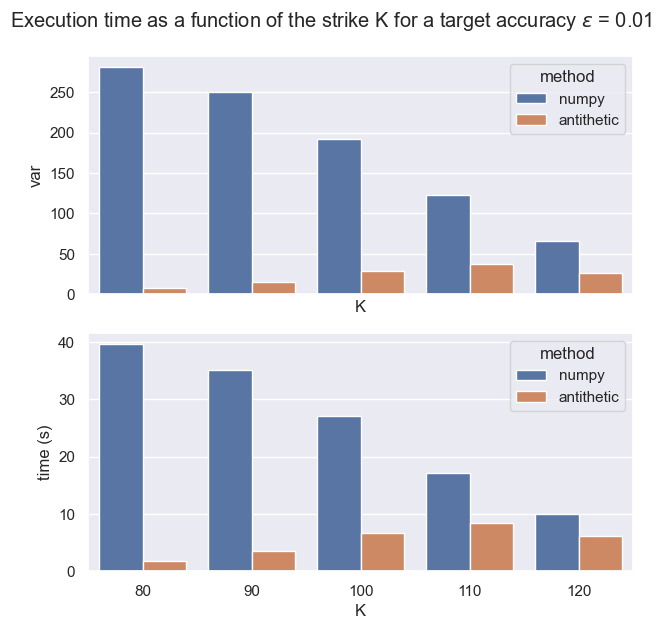

In [39]:
result = pd.concat([ result_numpy, result_antithetic ])
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6.4,6.4), 
                               sharex=True, layout="tight")
sns.barplot(data=result, x="K", y="var", hue="method", ax=ax1)
sns.barplot(data=result, x="K", y="time (s)", hue="method", ax=ax2)
fig.suptitle(fr"Execution time as a function of the strike K for a target accuracy $\epsilon$ = {epsilon}");

通过上面的柱状图我们可以看出，随着 $K$ 值的增大，普通 Monte Carlo 模拟的方差逐渐减小，而使用反向变量法的 Monte Carlo 模拟时方差随着 $K$ 值增大而增大。

---

在普通 Monte Carlo 方法中，随着行权价 K 的增大，绝大多数样本的 payoff 接近零，样本的离散性减小，因此估计器的方差随之减小。这与 Monte Carlo 方差的定义一致：样本的波动越小，方差越小。

---

在使用反向变量法进行方差缩减时，它的有效性依赖于构造的样本对 G_i 与 -G_i 的 payoff 具有高度负相关性，从而通过平均降低方差。

$$ Var(\frac{f(G_i)+f(-G_i)}{2}) = \frac{1}{4}\big(Var(f(G_i))+Var(f(-G_i))+2Cov(f(G_i),f(-G_i))\big) $$

随着 K 增大，payoff 逐渐接近零，这时 G_i 与 -G_i 的 payoff 对之间的负相关性减弱甚至消失。由于负相关性的缺失，反向变量法的估计器无法再有效降低方差，反而可能因为少数极端样本的贡献使总体方差略有增大。